# Driving styles and car type

In [2]:
import os
os.chdir('../data')

In [ ]:
import scipy
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM

In [3]:
driving_data = pd.read_csv("input/results-survey528393.csv")

In [4]:
print("Driving data", driving_data.shape)

Driving data (49, 334)


In [5]:
driving_data["condition"].value_counts().sort_index()

1    15
2    15
3    19
Name: condition, dtype: int64

## Preprocessing

Get results from the driving style scale that each participant responded and filter out the participants from the conditions other than "car type".

In [6]:
car_type_data = driving_data[driving_data["condition"] == 3]

In [7]:
# split car types
agg_family = car_type_data.columns[car_type_data.columns.str.fullmatch("aggfam.+\[SQ00[1-2]\]")]
def_family = car_type_data.columns[car_type_data.columns.str.fullmatch("deffam.+\[SQ00[1-2]\]")]

agg_sports = car_type_data.columns[car_type_data.columns.str.fullmatch("aggsport.+\[SQ00[1-2]\]")]
def_sports = car_type_data.columns[car_type_data.columns.str.fullmatch("defsport.+\[SQ00[1-2]\]")]

In [8]:
agg_sports

Index(['aggsports[SQ001]', 'aggsports[SQ002]', 'aggsports2[SQ001]',
       'aggsports2[SQ002]'],
      dtype='object')

In [9]:
conditions_data = pd.DataFrame(
    {
        "agg_family": car_type_data.loc[:, agg_family].mean(axis=1),
        "def_family": car_type_data.loc[:, def_family].mean(axis=1),
        "agg_sports": car_type_data.loc[:, agg_sports].mean(axis=1),
        "def_sports": car_type_data.loc[:, def_sports].mean(axis=1),
    }
)
car_type_data = car_type_data.join(conditions_data)

In [10]:
car_type_data.columns

Index(['id', 'submitdate', 'lastpage', 'startlanguage', 'seed', 'startdate',
       'datestamp', 'consent', 'consent2', 'generatecode',
       ...
       'SensationArrayTime', 'TrustArrayTime', 'groupTime177',
       'participationhoursTime', 'groupTime188', 'FeedbackTime', 'agg_family',
       'def_family', 'agg_sports', 'def_sports'],
      dtype='object', length=338)

In [11]:
car_type_data.to_csv("working/car_type_data.csv", index=False)
car_type_data.shape

(19, 338)

In [12]:
# get data in a different format (unpivot)
agg_family_data = pd.DataFrame(
    {
        "driving_style": "aggressive",
        "car_type": "family",
        "rating": car_type_data.loc[:, agg_family].mean(axis=1),
    }
)

def_family_data = pd.DataFrame(
    {
        "driving_style": "defensive",
        "car_type": "family",
        "rating": car_type_data.loc[:, def_family].mean(axis=1),
    }
)

agg_sports_data = pd.DataFrame(
    {
        "driving_style": "aggressive",
        "car_type": "sports",
        "rating": car_type_data.loc[:, agg_sports].mean(axis=1),
    }
)

def_sports_data = pd.DataFrame(
    {
        "driving_style": "defensive",
        "car_type": "sports",
        "rating": car_type_data.loc[:, def_sports].mean(axis=1),
    }
)

In [13]:
car_type_data_unpivot = pd.concat(
    [agg_family_data, def_family_data, agg_sports_data, def_sports_data]
)
car_type_data_unpivot = car_type_data_unpivot.reset_index().rename(columns={"index": "id"})
car_type_data_unpivot

,id,driving_style,car_type,rating
0,1,aggressive,family,2.25
1,24,aggressive,family,3.50
2,25,aggressive,family,3.25
3,27,aggressive,family,1.00
4,30,aggressive,family,2.50
...,...,...,...,...
71,44,defensive,sports,3.25
72,45,defensive,sports,1.75
73,46,defensive,sports,3.25
74,47,defensive,sports,2.50


In [47]:
driving_data.to_pickle("working/driving_data.pkl")
car_type_data.to_pickle("working/car_type_data.pkl")
car_type_data.to_csv("working/car_type_data.csv", index=False)   # for JASP
car_type_data_unpivot.to_pickle("working/car_type_data_unpivot.pkl")

In [48]:
car_type_data.columns

Index(['id', 'submitdate', 'lastpage', 'startlanguage', 'seed', 'startdate',
       'datestamp', 'consent', 'consent2', 'generatecode',
       ...
       'SensationArrayTime', 'TrustArrayTime', 'groupTime177',
       'participationhoursTime', 'groupTime188', 'FeedbackTime', 'agg_family',
       'def_family', 'agg_sports', 'def_sports'],
      dtype='object', length=338)

## Descriptive statistics

In [39]:
# import functions copied from my personal tools library https://github.com/javiercmh/datasci-tools

from scipy.stats import pearsonr


def corr(data, significance=False, decimals=3, sample_size=True):
    """Generates a correlation matrix with p-values and sample size, just like SPSS.

    Args:
        data (pandas.DataFrame): Data for calculating correlations.
        significance (bool): Determines whether to include asterisks in correlations.
        decimals (int): Used to round values.
        sample_size (bool): Determines whether to include sample size.

    Returns:
        pandas.DataFrame: SPSS-like correlation matrix.
    """
    # (adapted from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance)
    # generate matrices (r, p vals, sample size)
    rs = data.corr(method=lambda x, y: pearsonr(x, y)[0]).round(decimals)
    pvals = data.corr(method=lambda x, y: pearsonr(x, y)[1]).round(decimals)

    if significance:
        p = pvals.applymap(
            lambda x: "".join(["*" for t in [0.001, 0.01, 0.05] if x <= t])
        )  # matrix with asterisks
        rs = rs.astype(str) + p

    # (adapted from https://stackoverflow.com/questions/58282538/merging-pandas-dataframes-alternating-rows-without-soritng-rows)
    # create new index level enumerating the number of columns
    s1 = rs.assign(_col=np.arange(len(rs))).set_index("_col", append=True)
    s2 = pvals.assign(_col=np.arange(len(pvals))).set_index("_col", append=True)

    levels = [s1, s2]
    column_names = ("Pearson's r", "p-value")

    if sample_size:
        ns = (
            data.corr(method=lambda x, y: len(x)).replace(1, np.nan).round(decimals)
        )  # sample size = 1 would be misleading
        s3 = ns.assign(_col=np.arange(len(ns))).set_index("_col", append=True)

        levels.append(s3)
        column_names += ("Sample size",)

    # merge these matrices
    corr_matrix = (
        pd.concat(levels, keys=column_names)  # new index with each indicator
        .sort_index(kind="merge", level=2)
        .reset_index(level=2, drop=True)  # drop _col index
        .swaplevel(0, 1)
    )  # invert index levels

    return corr_matrix


def pie(
    values,
    labels=None,
    title="",
    slices=None,
    percent_only=False,
    explode=True,
    color="white",
):
    """Display a pie plot.

    Args:
        values (list): list or pandas.Series of unique values. Using value_counts() is highly recommended.
        labels (list): if None, indices of values will be used.
        title (str): header for the plot.
        slices (int): set a number of slices, to avoid clutter.
        percent_only (bool): if False it will show count and percent.
        explode (bool): slightly separate the slice with the highest value.
        color (str): text color.
    """
    if isinstance(values, list):
        values = pd.Series(values)

    if slices:  # debug
        other = values[slices:]
        values = values[:slices]
        values.index = values.index.astype(str)  # avoid problems with CategoricalIndex
        values["Other"] = other.sum()

    if not labels:
        labels = values.index
        if labels.dtype == "O":
            labels = labels.str.capitalize()

    def show_value_and_percent(x):
        if not (percent_only):
            return "{:.1f}%\n({:.0f})".format(x, total * x / 100)
        else:
            return "{:.0f}%".format(x, total * x / 100)

    explode = (
        [0.1] + [0 for l in range(len(labels) - 1)]
        if explode
        else [0 for l in range(len(labels))]
    )
    total = sum(values)

    fig, ax = plt.subplots()
    a, b, autotexts = ax.pie(
        values,
        labels=labels,
        explode=explode,
        autopct=show_value_and_percent,
        shadow=True,
        startangle=90,
    )
    plt.setp(autotexts, **{"color": color, "fontsize": 12.5})
    ax.set_title(title, fontweight="bold")
    plt.show()

### Demographics

In [15]:
driving_data = pd.read_pickle("working/driving_data.pkl")
car_type_data = pd.read_pickle("working/car_type_data.pkl")
car_type_data_unpivot = pd.read_pickle("working/car_type_data_unpivot.pkl")

In [16]:
descriptive_columns = [
    "drivingxpcat",     # driving in the last 12 months
    "educationyears",
    "age",
    "gender",
    "drivingxp",        # years of experience driving cars
    "educationlevel",
]

In [17]:
descriptive_data = car_type_data[descriptive_columns]
descriptive_data.shape

(19, 6)

In [18]:
print("Descriptive data of car type condition", descriptive_data.shape, "\n")
for nominal_column in ["drivingxpcat", "gender", "educationlevel"]:
    print(descriptive_data[nominal_column].value_counts(normalize=True), "\n")

Descriptive data of car type condition (19, 6) 

Once a week.               0.368421
Less than once a month.    0.315789
Not at all.                0.105263
Almost daily.              0.105263
Once a month.              0.105263
Name: drivingxpcat, dtype: float64 

Female    0.526316
Male      0.473684
Name: gender, dtype: float64 

Bachelor degree                         0.631579
Masters/Diploma degree                  0.263158
Vocational training/Berufsausbildung    0.052632
Doctoral degree                         0.052632
Name: educationlevel, dtype: float64 



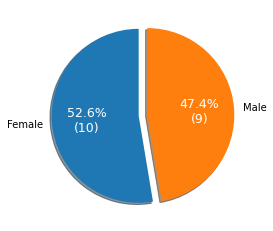

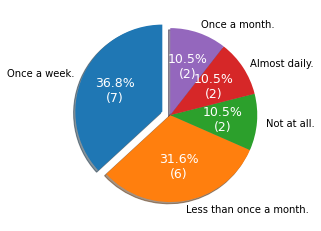

In [46]:
#Args:
    # values (list): list or pandas.Series of unique values. Using value_counts() is highly recommended.
    # labels (list): if None, indices of values will be used.
    # title (str): header for the plot.
    # slices (int): set a number of slices, to avoid clutter.
    # percent_only (bool): if False it will show count and percent.
    # explode (bool): slightly separate the slice with the highest value.
    # color (str): text color.

pie(descriptive_data["gender"].value_counts())
pie(descriptive_data["drivingxpcat"].value_counts())

In [19]:
descriptive_data.describe()

,educationyears,age,drivingxp
count,19.000000,18.000000,19.000000
mean,16.684211,28.722222,8.894737
std,3.317506,8.308787,9.024010
min,6.000000,21.000000,1.000000
25%,16.500000,24.500000,4.000000
50%,18.000000,26.000000,7.000000
75%,18.000000,30.750000,11.000000
max,20.000000,59.000000,41.000000


In [58]:
descriptive_data["age"].median()

26.0

Dichotomize some variables

In [20]:
descriptive_data.loc[:, "frequent_driver"] = descriptive_data["drivingxpcat"].str.contains("week|daily").astype(int)
descriptive_data.loc[:, "female"] = descriptive_data["gender"].str.contains("Female").astype(int)
descriptive_data

/tmp/ipykernel_12271/839021267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptive_data.loc[:, "frequent_driver"] = descriptive_data["drivingxpcat"].str.contains("week|daily").astype(int)
/tmp/ipykernel_12271/839021267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  descriptive_data.loc[:, "female"] = descriptive_data["gender"].str.contains("Female").astype(int)


,drivingxpcat,educationyears,age,gender,drivingxp,educationlevel,frequent_driver,female
1,Once a week.,18,24.0,Male,2,Bachelor degree,1,0
24,Less than once a month.,19,30.0,Female,9,Masters/Diploma degree,0,1
25,Less than once a month.,17,23.0,Male,4,Bachelor degree,0,0
27,Not at all.,19,26.0,Female,1,Masters/Diploma degree,0,1
30,Once a week.,18,26.0,Female,5,Bachelor degree,1,1
31,Almost daily.,15,21.0,Female,2,Bachelor degree,1,1
32,Less than once a month.,12,NaN,Male,16,Bachelor degree,0,0
36,Not at all.,18,26.0,Male,4,Bachelor degree,0,0
38,Less than once a month.,17,27.0,Female,1,Bachelor degree,0,1
39,Less than once a month.,18,24.0,Male,7,Bachelor degree,0,0


In [21]:
descriptive_data["age"].value_counts().sort_index()

21.0    1
23.0    2
24.0    2
26.0    5
27.0    1
28.0    1
30.0    1
31.0    1
32.0    2
33.0    1
59.0    1
Name: age, dtype: int64

In [22]:
family = car_type_data_unpivot.loc[car_type_data_unpivot["car_type"] == "family", "rating"]
sports = car_type_data_unpivot.loc[car_type_data_unpivot["car_type"] == "sports", "rating"]

print("family:", family.mean(), "sports:", sports.mean())

family: 2.611842105263158 sports: 2.875


In [23]:
aggressive = car_type_data_unpivot.loc[car_type_data_unpivot["driving_style"] == "aggressive", "rating"]
defensive = car_type_data_unpivot.loc[car_type_data_unpivot["driving_style"] == "defensive", "rating"]

print("aggressive:", aggressive.mean(), "defensive:", defensive.mean())

aggressive: 2.6907894736842106 defensive: 2.7960526315789473


In [55]:
mean_ratings = car_type_data_unpivot.groupby(["id"]).mean()
mean_by_car_type = car_type_data_unpivot.groupby(["car_type"]).mean().drop(["id"], axis=1)
mean_by_driving_style = car_type_data_unpivot.groupby(["driving_style"]).mean().drop(["id"], axis=1)

In [56]:
mean_by_car_type

,rating
car_type,
family,2.611842
sports,2.875000


In [57]:
mean_by_driving_style

,rating
driving_style,
aggressive,2.690789
defensive,2.796053


In [25]:
# combine mean_ratings with descriptive_data
descriptive_numerical_data = mean_ratings.join(descriptive_data.select_dtypes(include=np.number))
descriptive_numerical_data

,rating,educationyears,age,drivingxp,frequent_driver,female
id,,,,,,
1,2.6250,18,24.0,2,1,0
24,2.6875,19,30.0,9,0,1
25,3.6875,17,23.0,4,0,0
27,2.5625,19,26.0,1,0,1
30,2.3125,18,26.0,5,1,1
31,1.9375,15,21.0,2,1,1
32,3.1250,12,NaN,16,0,0
36,3.0000,18,26.0,4,0,0
38,2.6250,17,27.0,1,0,1


In [26]:
# do it for all participants
rating_columns = driving_data.columns[driving_data.columns.str.contains("(agg|def).+\[SQ00[1-2]\]")]
all_mean_ratings = pd.DataFrame(driving_data.loc[:, rating_columns].mean(axis=1), columns=["rating"])

all_descriptive_data = driving_data[descriptive_columns]
all_descriptive_data.loc[:, "frequent_driver"] = all_descriptive_data["drivingxpcat"].str.contains("week|daily").astype(int)
all_descriptive_data.loc[:, "female"] = all_descriptive_data["gender"].str.contains("Female").astype(int)

all_descriptive_numerical_data = all_mean_ratings.join(all_descriptive_data.select_dtypes(include=np.number))
all_descriptive_numerical_data.head()

/tmp/ipykernel_12271/154866836.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rating_columns = driving_data.columns[driving_data.columns.str.contains("(agg|def).+\[SQ00[1-2]\]")]
/tmp/ipykernel_12271/154866836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_descriptive_data.loc[:, "frequent_driver"] = all_descriptive_data["drivingxpcat"].str.contains("week|daily").astype(int)
/tmp/ipykernel_12271/154866836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,rating,educationyears,age,drivingxp,frequent_driver,female
0,3.500,21,25.0,6,0,0
1,2.625,18,24.0,2,1,0
2,4.125,20,28.0,10,0,0
3,2.375,15,23.0,7,1,0
4,4.250,25,32.0,14,1,1


In [28]:
corr(descriptive_numerical_data, significance=True, sample_size=True)

rating educationyears       age drivingxp  \
rating          Pearson's r     1.0         -0.406    -0.231    -0.054   
                Sample size     NaN           19.0      18.0      19.0   
                p-value         1.0          0.084     0.357     0.825   
educationyears  Pearson's r  -0.406            1.0    -0.118    -0.254   
                Sample size    19.0            NaN      18.0      19.0   
                p-value       0.084            1.0     0.642     0.295   
age             Pearson's r  -0.231         -0.118       1.0  0.925***   
                Sample size    18.0           18.0       NaN      18.0   
                p-value       0.357          0.642       1.0       0.0   
drivingxp       Pearson's r  -0.054         -0.254  0.925***       1.0   
                Sample size    19.0           19.0      18.0       NaN   
                p-value       0.825          0.295       0.0       1.0   
frequent_driver Pearson's r  -0.446          0.093     0.296     0.215   
                Sample size    19.0           19.0      18.0      19.0   
                p-value       0.056          0.706     0.233     0.376   
female          Pearson's r  -0.292          0.201     0.288     0.085   
                Sample size    19.0           19.0      18.0      19.0   
                p-value       0.225          0.409     0.247      0.73   

                            frequent_driver  female  
rating          Pearson's r          -0.446  -0.292  
                Sample size            19.0    19.0  
                p-value               0.056   0.225  
educationyears  Pearson's r           0.093   0.201  
                Sample size            19.0    19.0  
                p-value               0.706   0.409  
age             Pearson's r           0.296   0.288  
                Sample size            18.0    18.0  
                p-value               0.233   0.247  
drivingxp       Pearson's r           0.215   0.085  
                Sample size            19.0    19.0  
                p-value               0.376    0.73  
frequent_driver Pearson's r             1.0   0.056  
                Sample size             NaN    19.0  
                p-value                 1.0   0.821  
female          Pearson's r           0.056     1.0  
                Sample size            19.0     NaN  
                p-value               0.821     1.0

In [29]:
corr(all_descriptive_numerical_data, significance=True, sample_size=True)

rating educationyears       age drivingxp  \
rating          Pearson's r     1.0          0.025    -0.219    -0.149   
                Sample size     NaN           49.0      47.0      49.0   
                p-value         1.0          0.863      0.14     0.306   
educationyears  Pearson's r   0.025            1.0     0.101     0.042   
                Sample size    49.0            NaN      47.0      49.0   
                p-value       0.863            1.0     0.501     0.775   
age             Pearson's r  -0.219          0.101       1.0  0.964***   
                Sample size    47.0           47.0       NaN      47.0   
                p-value        0.14          0.501       1.0       0.0   
drivingxp       Pearson's r  -0.149          0.042  0.964***       1.0   
                Sample size    49.0           49.0      47.0       NaN   
                p-value       0.306          0.775       0.0       1.0   
frequent_driver Pearson's r  -0.201          0.117    0.338*    0.356*   
                Sample size    49.0           49.0      47.0      49.0   
                p-value       0.166          0.424      0.02     0.012   
female          Pearson's r   0.004          0.102     0.113     0.014   
                Sample size    49.0           49.0      47.0      49.0   
                p-value       0.979          0.485     0.449     0.922   

                            frequent_driver female  
rating          Pearson's r          -0.201  0.004  
                Sample size            49.0   49.0  
                p-value               0.166  0.979  
educationyears  Pearson's r           0.117  0.102  
                Sample size            49.0   49.0  
                p-value               0.424  0.485  
age             Pearson's r          0.338*  0.113  
                Sample size            47.0   47.0  
                p-value                0.02  0.449  
drivingxp       Pearson's r          0.356*  0.014  
                Sample size            49.0   49.0  
                p-value               0.012  0.922  
frequent_driver Pearson's r             1.0  0.118  
                Sample size             NaN   49.0  
                p-value                 1.0   0.42  
female          Pearson's r           0.118    1.0  
                Sample size            49.0    NaN  
                p-value                0.42    1.0

## Results

### t-test

Comparing ratings of aggressive/defensive driving behaviours.

First comparing means for the whole data.

Then comparing means for the car type condition.

We used independent samples t-test for both comparisons.

In [30]:
# perform t test on driving data
pg.ttest(aggressive, defensive, alternative="greater")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.644235,74,greater,0.739292,"[-0.38, inf]",0.147798,0.568,0.011208


In [31]:
aggressive.mean() - defensive.mean()

-0.10526315789473673

In [32]:
# perform t test on car_type_data
pg.ttest(family, sports, alternative="greater")

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.634835,74,greater,0.946835,"[-0.53, inf]",0.375057,0.669,0.000548


### Repeated measures ANOVA

In [33]:
car_type_data_unpivot.head()

,id,driving_style,car_type,rating
0,1,aggressive,family,2.25
1,24,aggressive,family,3.50
2,25,aggressive,family,3.25
3,27,aggressive,family,1.00
4,30,aggressive,family,2.50


In [34]:
print(
    AnovaRM(
        data=car_type_data_unpivot, depvar="rating", subject="id", within=["driving_style", "car_type"]
    ).fit()
)

                       Anova
                       F Value Num DF  Den DF Pr > F
----------------------------------------------------
driving_style           0.3859 1.0000 18.0000 0.5423
car_type                5.7030 1.0000 18.0000 0.0281
driving_style:car_type  0.8403 1.0000 18.0000 0.3714

